In [1]:
import numpy as np
import tensorflow as tf
from scipy.special import i0 as bessel

In [34]:
def log_bessel_approx_tf(x, m=5):
    def _log_bessel_approx_0(x):
        bessel_taylor_coefs = np.asarray([1.00000000e+00, 2.50000000e-01, 1.56250000e-02,
                                  4.34027778e-04, 6.78168403e-06], dtype='float32')
        deg = tf.reshape(tf.range(0, m, 1)*2, [1, -1])
        n_rows = tf.shape(x)[0]
        x_tiled = tf.tile(x, [1, m])
        deg_tiled = tf.tile(deg, [n_rows, 1])
        coef_tiled = tf.tile(bessel_taylor_coefs[0:m].reshape(1, m), [n_rows, 1])
        val = tf.log(tf.reduce_sum(tf.pow(x_tiled, tf.to_float(deg_tiled))*coef_tiled, axis=1))
        return tf.reshape(val, [-1,1])
    def _log_bessel_approx_large(x):
        return x - 0.5*tf.log(2*np.pi*x)
    res = tf.where(x>5.0, _log_bessel_approx_large(x), _log_bessel_approx_0(x))
    return res

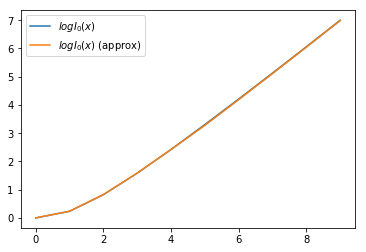

In [41]:
import matplotlib.pyplot as plt 
%matplotlib inline

x_vals = np.arange(0,10).reshape(-1,1)

x_tf = tf.placeholder(tf.float32, shape=[None, 1])
log_bessel_tf = log_bessel_approx_tf(x_tf)

with tf.Session() as sess:
    log_bessel_vals_true = np.log(bessel(x_vals))
    log_bessel_vals_approx = log_bessel_tf.eval(feed_dict={x_tf:x_vals})

plt.plot(x_vals, log_bessel_vals_true, label='$log I_0(x)$')
plt.plot(x_vals, log_bessel_vals_approx, label='$log I_0(x)$ (approx)')

plt.legend()
plt.show()

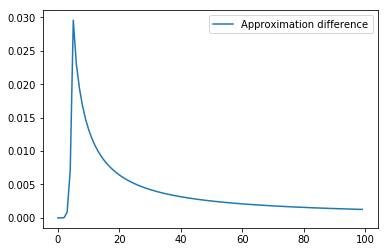

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(x_vals, np.abs(log_bessel_vals_true-log_bessel_vals_approx), label='Approximation difference')

plt.legend()
plt.show()

In [5]:
def von_mises_neg_log_likelihood_np(cosin_sim, kappa):
    log_likelihood = kappa * cosin_sim - \
                     np.log(2 * np.pi) - np.log(bessel(kappa))
    return -log_likelihood

def von_mises_neg_log_likelihood_tf(cosin_sim, kappa):
    log_likelihood = kappa * cosin_sim - \
                     tf.log(2 * np.pi) - log_bessel_approx_tf(kappa)
    return -log_likelihood

In [7]:
cosin_sim_tf = tf.placeholder(tf.float32, shape=[None, 1])
kappa_tf = tf.placeholder(tf.float32, shape=[None, 1])

kappa = np.arange(-100, 100, 0.1).reshape(-1,1)
cosin_sim = np.ones(kappa.shape) # np.arange(0.01, 0.99, 0.1).reshape(-1,1)

von_mises_neg_log_likelihood = von_mises_neg_log_likelihood_tf(cosin_sim_tf, kappa_tf)
feed_dict = {cosin_sim_tf: cosin_sim, kappa_tf: kappa}

with tf.Session() as sess:
    neg_log_like = von_mises_neg_log_likelihood.eval(feed_dict=feed_dict)

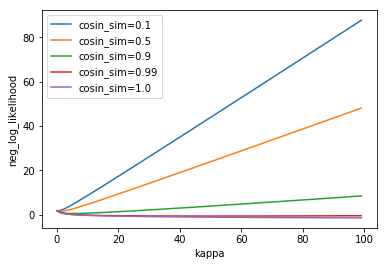

In [40]:
import matplotlib.pyplot as plt 

%matplotlib inline

cosin_sim_tf = tf.placeholder(tf.float32, shape=[None, 1])
kappa_tf = tf.placeholder(tf.float32, shape=[None, 1])
vm_log_likelihood = von_mises_neg_log_likelihood_tf(cosin_sim_tf, kappa_tf)

kappa = np.arange(0,100).reshape(-1,1)
cosin_sim = np.ones([kappa.shape[0],1])

with tf.Session() as sess:
    loss1 = vm_log_likelihood.eval(feed_dict={cosin_sim_tf:cosin_sim*0.1, kappa_tf:kappa})
    loss2 = vm_log_likelihood.eval(feed_dict={cosin_sim_tf:cosin_sim*0.5, kappa_tf:kappa})
    loss3 = vm_log_likelihood.eval(feed_dict={cosin_sim_tf:cosin_sim*0.9, kappa_tf:kappa})
    loss4 = vm_log_likelihood.eval(feed_dict={cosin_sim_tf:cosin_sim*0.99, kappa_tf:kappa})
    loss5 = vm_log_likelihood.eval(feed_dict={cosin_sim_tf:cosin_sim, kappa_tf:kappa})
    
plt.plot(kappa, loss1, label='cosin_sim=0.1')
plt.plot(kappa, loss2, label='cosin_sim=0.5')
plt.plot(kappa, loss3, label='cosin_sim=0.9')
plt.plot(kappa, loss4, label='cosin_sim=0.99')
plt.plot(kappa, loss5, label='cosin_sim=1.0')

#plt.plot(kappa, loss, label='Loss dependent on kappa')
#plt.plot(kappa, loss, label='Loss dependent on kappa')

plt.xlabel('kappa')
plt.ylabel('neg_log_likelihood')

plt.legend()
plt.show()

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


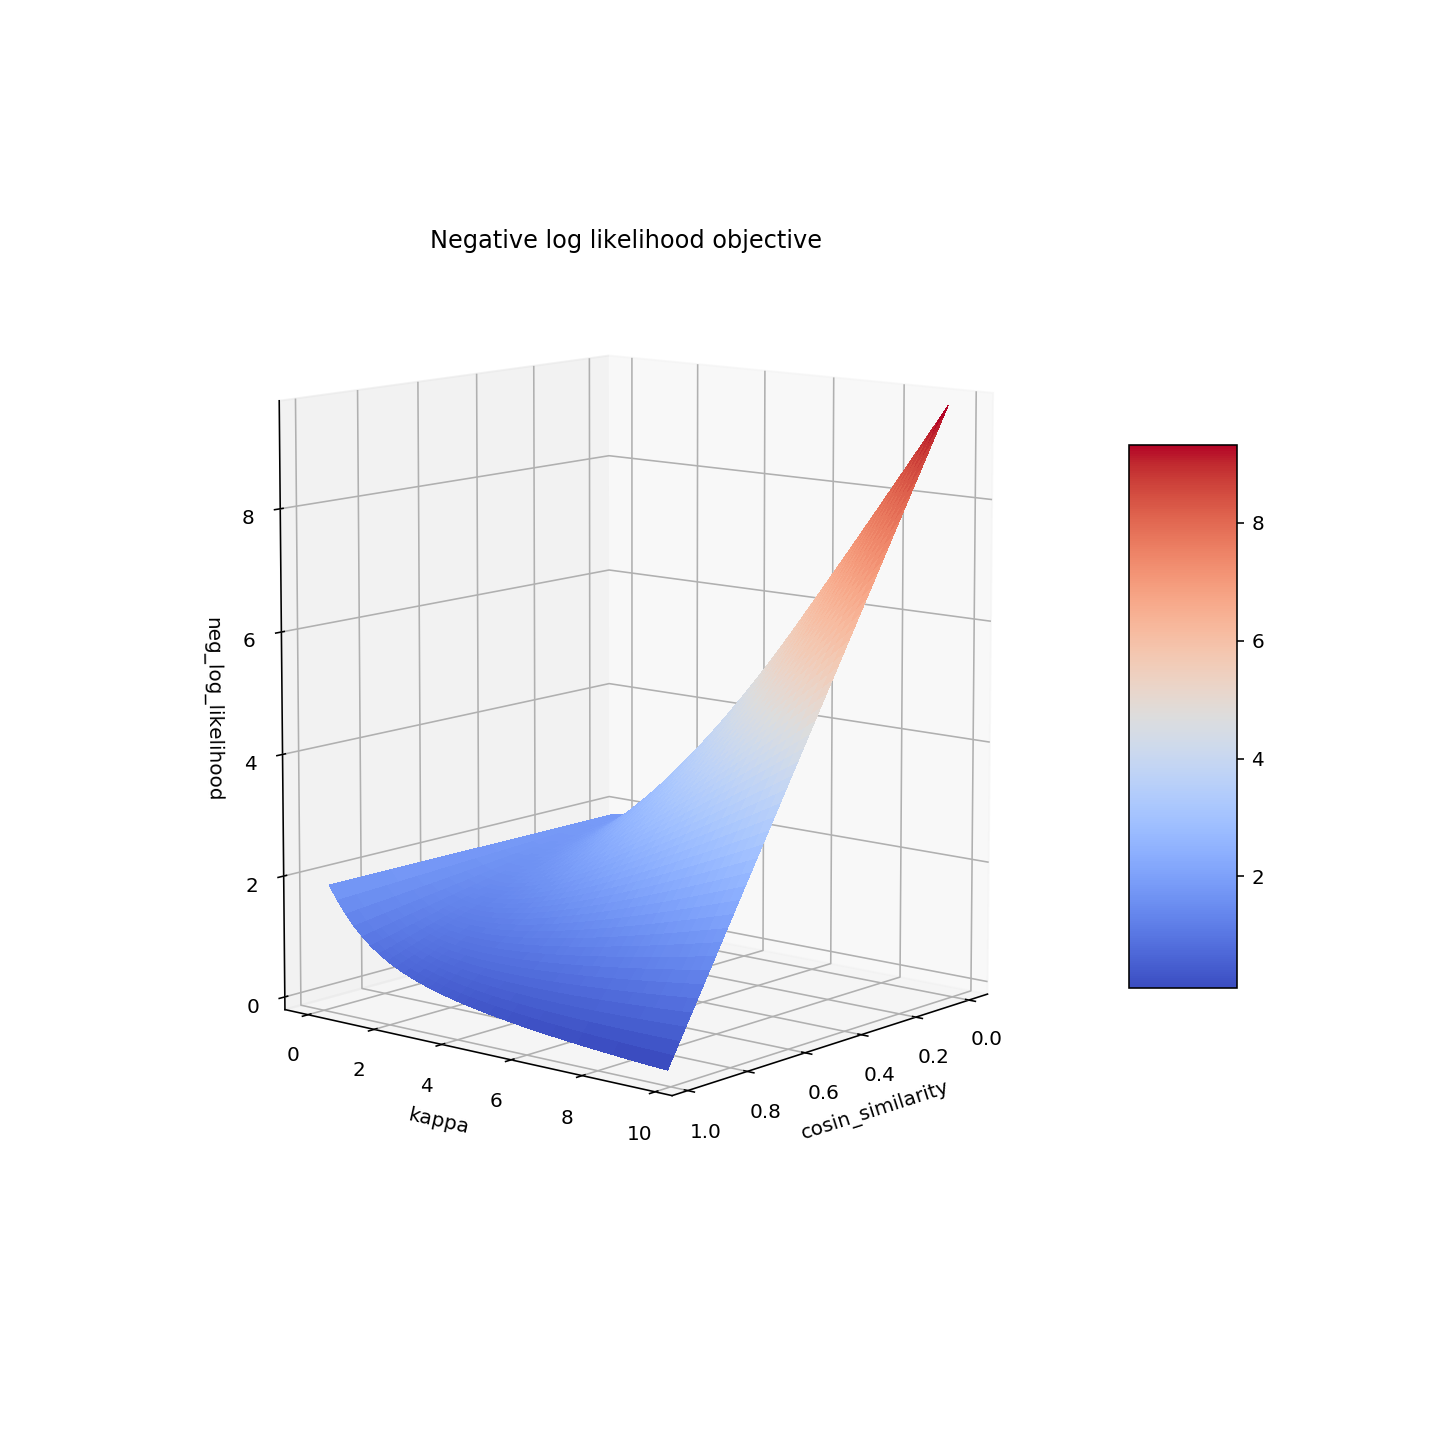

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


cosin_dist = np.arange(0, 0.99, 0.01)
kappa = np.arange(0, 10, 0.25)
cosin_dist, kappa = np.meshgrid(cosin_dist, kappa)
neg_log_likelihood = -(kappa * cosin_dist - np.log(2 * np.pi) - np.log(bessel(kappa)))

surf = ax.plot_surface(cosin_dist, kappa, neg_log_likelihood, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('cosin_similarity')
ax.set_ylabel('kappa')
ax.set_zlabel('neg_log_likelihood')
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("Negative log likelihood objective")
plt.show()